In [74]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [75]:
def f(x):
    return 3*x**2 - 4*x +5

In [76]:
f(3.0)

20.0

In [77]:
list_xs = np.arange(-5, 5, 0.25)

In [78]:
list_ys = f(list_xs)

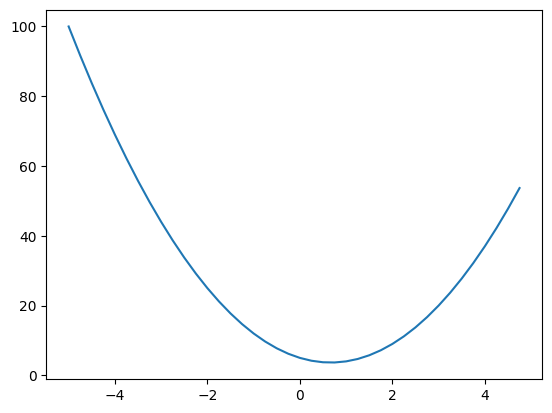

In [79]:
plt.plot(list_xs, list_ys)

In [80]:
h = 0.00000000001
x = 3.0
f(x + h)

20.000000000140002

In [81]:
( f(x + h) - f(x) ) / h 

14.000178794049134

In [82]:
h = 0.00000000001
x = -3.0
( f(x + h) - f(x) ) / h 

-21.999824184604222

In [83]:
h = 0.00000000001
x = 2/3
( f(x + h) - f(x) ) / h 

0.0

In [84]:
a, b, c = 2.0, -3.0, 10.0
d = a*b + c
print(d)

4.0


In [85]:
a, b, c = 2.0, -3.0, 10.0
h = 0.00000000001

d1 = a*b + c
a += h
d2 = a*b + c

print(f'slope of a = ( d2 ({d2}) - d1 ({d1}) ) / h ({h}) = {(d2-d1)/h}')

slope of a = ( d2 (3.99999999997) - d1 (4.0) ) / h (1e-11) = -3.000000248221113


In [86]:
a, b, c = 2.0, -3.0, 10.0
h = 0.00000000001

d1 = a*b + c
b += h
d2 = a*b + c

print(f'slope of b = ( d2 ({d2}) - d1 ({d1}) ) / h ({h}) = {(d2-d1)/h}')

slope of b = ( d2 (4.00000000002) - d1 (4.0) ) / h (1e-11) = 2.000000165480742


In [87]:
a, b, c = 2.0, -3.0, 10.0
h = 0.00000000001

d1 = a*b + c
c += h
d2 = a*b + c

print(f'slope of c = ( d2 ({d2}) - d1 ({d1}) ) / h ({h}) = {(d2-d1)/h}')

slope of c = ( d2 (4.000000000009999) - d1 (4.0) ) / h (1e-11) = 0.9999112648984011


In [88]:
class Value:

    def ensure_value(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        return other

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data = {self.data})'

    def __add__(self, other):
        other = self.ensure_value(other) # make other Value if not already, e.g. if int, float
        
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # self.grad += out.grad * 1.0       # using += here (and in mul, and tanh, because gradients should accumulate
            # other.grad  += out.grad * 1.0     # important when e.g. both self and other are the same variable ( = rather than += would overwrite )
            
            grad = out.grad * 1.0               # improvement suggested by GPT
            self.grad += grad                   # karpathy's fix still generates the wrong gradients by overwriting
            other.grad += grad
                                        
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = self.ensure_value(other)
        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        
        return out
        
    def __rmul__(self, other):
        return self * other
        
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * ( self ** (other - 1) ) * out.grad         # power rule * out.grad
        
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        other = self.ensure_value(other)
        return self + (-other)

    def __rsub__(self, other):
        return Value(other) - self

    # NB Karpathy's truediv does not work for me (generates an error), and I think it's because it relies on pow, which asserts an int
    # the below is an alternative suggested by GPT, and seems to generate better results
    def __truediv__(self, other):
        other = self.ensure_value(other)
        out = Value(self.data / other.data, (self, other), '/')
    
        def _backward():
            self.grad += out.grad / other.data
            if isinstance(other, Value):
                other.grad -= out.grad * self.data / (other.data ** 2)
    
        out._backward = _backward
        return out

    # Karpathy's truediv
    """
    def __truediv__(self, other):
        return self * other ** -1
    """
        
    def tanh(self):
        x = self
        if isinstance(x, Value):  # check if x is a Value instance
            t = (math.exp(2*x.data) - 1) / (math.exp(2*x.data) + 1)
        else:
            t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1 - t**2)

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data # derivative of e is e
        
        out._backward = _backward
        
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()



In [89]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
d = a * b
d

Value(data = -6.0)

In [90]:
c = Value(10.0, label = 'c')
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'

In [91]:
e, e._prev, e._op

(Value(data = 4.0), {Value(data = -6.0), Value(data = 10.0)}, '+')

In [92]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return(nodes, edges)

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value, create a rectangular node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if has operation, create op node
            dot.node(name = uid + n._op, label = n._op)
            # and connect...
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to n2 op node
        dot.edge( str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [93]:
f = Value(-2.0, label = 'f')
L = e*f
L.label = 'L'

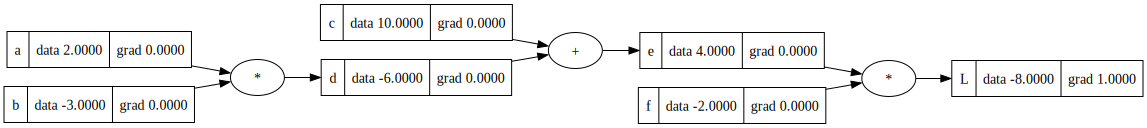

In [94]:
L.grad = 1
draw_dot(L)

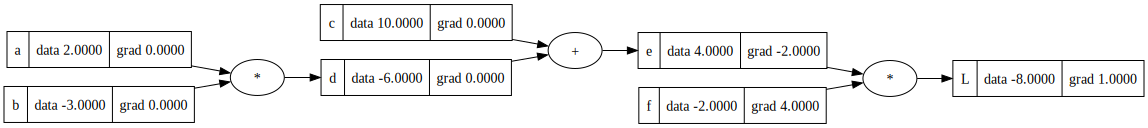

In [95]:
# get derivate of L with respect to e and f

e.grad = f.data
f.grad = e.data

draw_dot(L)

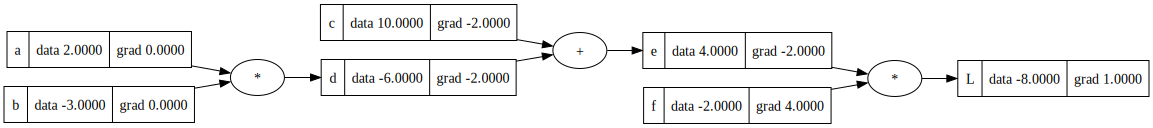

In [96]:
# get derivate of L with respect to c and d via chain rule

# e with respect to c and d has a derivative of 1
# dL/dc = dL/de * de/dc = -2.0 * 1.0
# same for dd, so:

c.grad = e.grad * 1
d.grad = e.grad * 1

draw_dot(L)

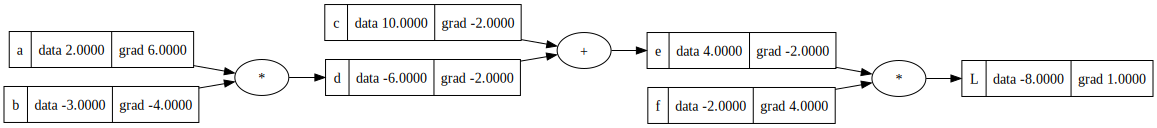

In [97]:
# get derivate of L with respect to a and b via chain rule

# dL/da = dL/de * de/dd * dd/da = -2.0 * 1.0 * -3.0
# and similar for b, so:

a.grad = d.grad * b.data
b.grad = d.grad * a.data

draw_dot(L)

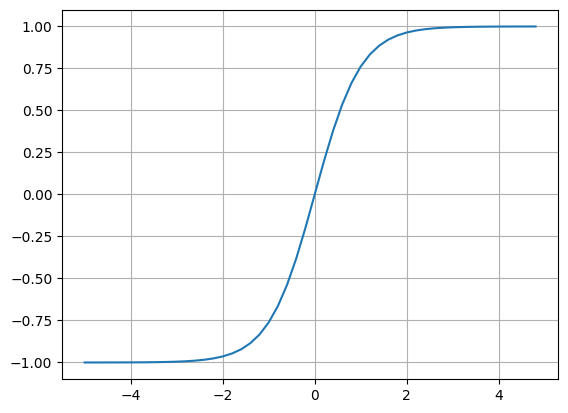

In [98]:
# tanh activation function
x = (np.arange(-5,5,0.2))
y = np.tanh(x)
plt.plot(x, y) ; plt.grid()

In [99]:
# creating weights and biases

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.7, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

sum_x1w1_x1w2 = x1w1 + x2w2; sum_x1w1_x1w2.label = 'x1w1 + x2w2'
n = sum_x1w1_x1w2 + b; n.label = 'n'

o = n.tanh() ; o.label = 'o'

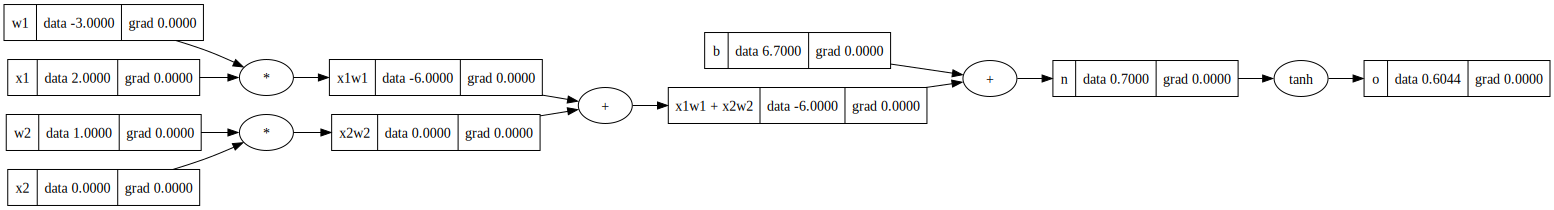

In [100]:
draw_dot(o)

In [101]:
# increase bias to 6.88..

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195423, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

sum_x1w1_x1w2 = x1w1 + x2w2; sum_x1w1_x1w2.label = 'x1w1 + x2w2'
n = sum_x1w1_x1w2 + b; n.label = 'n'

o = n.tanh() ; o.label = 'o'

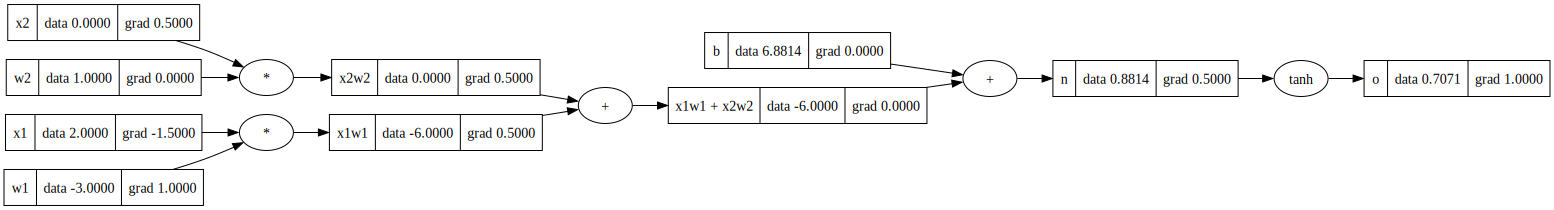

In [102]:
# do/do = 1, so:

o.grad = 1.0

# get do/dn, which is given by 1 - tanh(n)^2 (reference available on wikipedia)
# we already know that n.tanh() = o, so:

n.grad = 1 - o.data**2

# gradient flows back through + operation

x1w1.grad = n.grad * 1
x2w2.grad = n.grad * 1

# ws and xs end up with their scalars multiplied by their "child grads" (ad hoc terminology, lack the proper one), so:

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

In [103]:
# redefine values (leaving grads empty again)
# (we intend to use the _backward function we just created in 168 (Value class definition) to fill in the grads automatically)

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195423, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

sum_x1w1_x1w2 = x1w1 + x2w2; sum_x1w1_x1w2.label = 'x1w1 + x2w2'
n = sum_x1w1_x1w2 + b; n.label = 'n'

o = n.tanh() ; o.label = 'o'

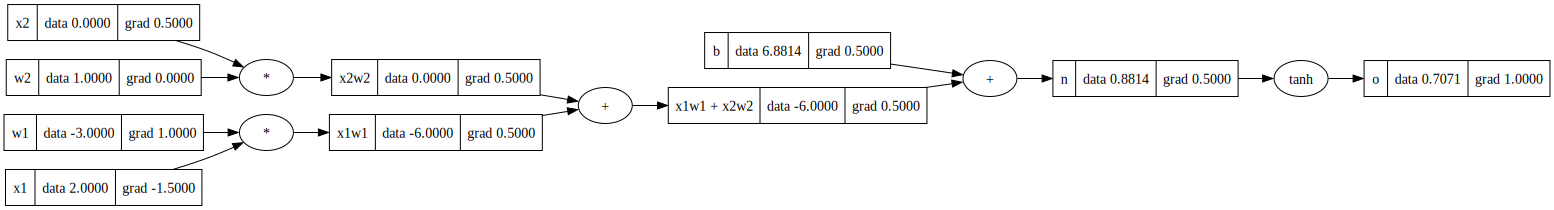

In [104]:
# generating the grads with ._backward

# first set o.grad to 1 as base case
o.grad = 1.0

# then back propagate ._backward through the network
o._backward()
n._backward()
b._backward()
sum_x1w1_x1w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

In [105]:
# redefine values (leaving grads empty again)
# (we intend to use the _backward function we just created in 168 (Value class definition) to fill in the grads automatically)

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195423, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

sum_x1w1_x1w2 = x1w1 + x2w2; sum_x1w1_x1w2.label = 'x1w1 + x2w2'
n = sum_x1w1_x1w2 + b; n.label = 'n'

o = n.tanh() ; o.label = 'o'

In [106]:
# first set o.grad to 1 as base case
o.grad = 1.0

In [107]:
# build a topological graph to control back propagation

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo         

[Value(data = 6.881373587019542),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = 0.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195423),
 Value(data = 0.7071067811865471)]

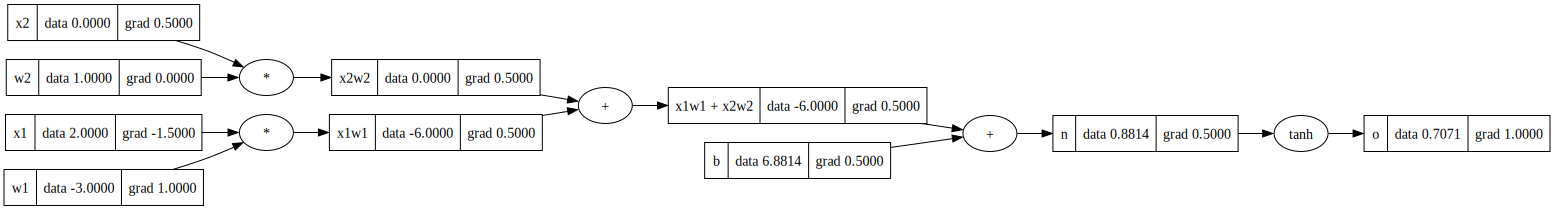

In [108]:
# reverse order

for node in reversed(topo):
    node._backward()

draw_dot(o)

In [109]:
# add above code to Value class

# run cell a few rows up to redefine values and set grads to 0


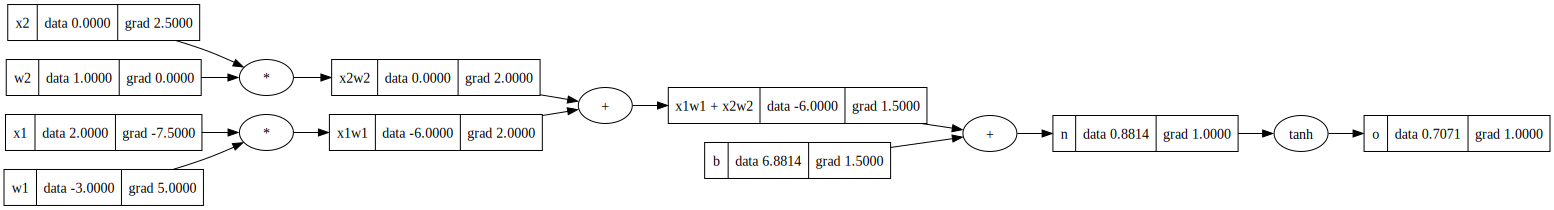

In [110]:
o.grad = 1.0

o.backward()

draw_dot(o)

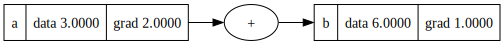

In [111]:
# example to highlight existing bug (now fixed) in which gradients would overwrite if using same var twice
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

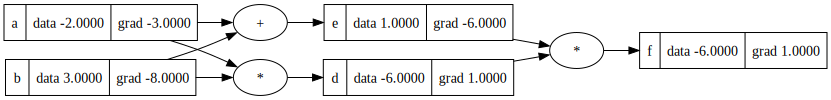

In [112]:
# example 2
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()

draw_dot(f)


In [113]:
# change definition of o to run tanh atomically, bit by bit

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195423, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

sum_x1w1_x1w2 = x1w1 + x2w2; sum_x1w1_x1w2.label = 'x1w1 + x2w2'
n = sum_x1w1_x1w2 + b; n.label = 'n'

n = (x1w1 + x2w2) + b

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

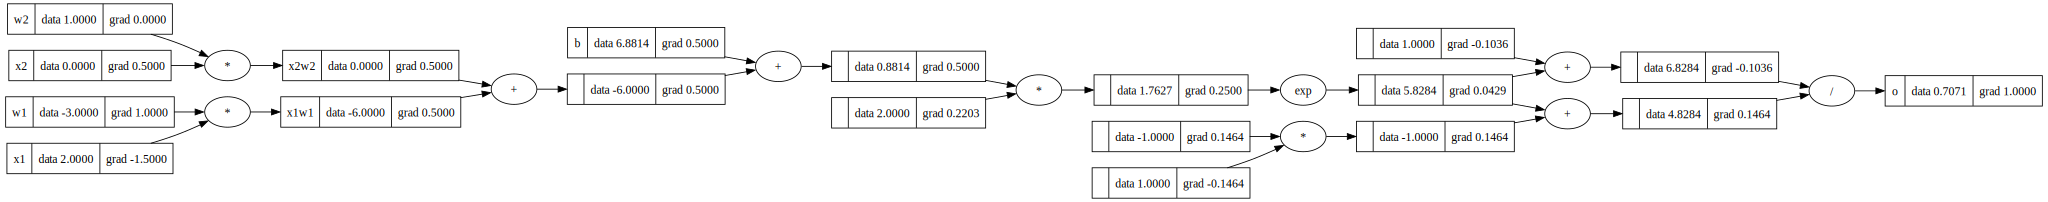

In [114]:
# Note that this returns a / node, while Karpathy's uses **-1
# Reasons explained in note on truediv in Value class definition
o.backward()
draw_dot(o)

In [115]:
#Let's do everything with PyTorch




In [116]:
import torch
import random

In [117]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195423]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('o', o.data.item(),'\n---')
o.backward()

print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

o 0.7071066904050358 
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [136]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((xi * wi for xi, wi in zip(x, self.w)), 
                  self.b) # sums starting at self.b (ie intrinsically adds the bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [137]:
# create and test single Neuron

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data = 0.27457510911237815)

In [138]:
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # returns as float rather than list if only one value
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [139]:
# create and test single Layer

n = Layer(2,3)
n(x)

[Value(data = 0.44822454003433687),
 Value(data = -0.8784457596861247),
 Value(data = -0.0836775680633132)]

In [140]:
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [267]:
# create and test a Multi-layered Perceptron

x = [2.0, 3.0, -1.0] # 3-Dimensional input
n = MLP(3, [4, 4, 1]) # 3 inputs into two size-4 hidden layers, and 1 output
n(x)

Value(data = 0.13212364127162793)

In [268]:
print(f'Number of parameters: {len(n.parameters())}\nAll parameters: {n.parameters()}')

Number of parameters: 41
All parameters: [Value(data = 0.2072359004915707), Value(data = -0.550641615878984), Value(data = 0.9965953446509215), Value(data = -0.3542310220211953), Value(data = 0.2395007539583629), Value(data = 0.17236139791304983), Value(data = -0.6906335611260388), Value(data = -0.1504263139107389), Value(data = 0.052433661936357234), Value(data = -0.32549538948160905), Value(data = 0.5068389493633811), Value(data = -0.8023359017873213), Value(data = -0.6693170039750405), Value(data = -0.21458068948994447), Value(data = 0.0421694670708046), Value(data = 0.6813500096378655), Value(data = -0.18460903777449622), Value(data = 0.9005627969208998), Value(data = 0.13573627155368584), Value(data = 0.9263280154871316), Value(data = -0.7216542213437409), Value(data = 0.32800872443219786), Value(data = 0.17082474930844116), Value(data = -0.8800648769291097), Value(data = -0.28803651871861424), Value(data = 0.5958540772684031), Value(data = 0.1979126863781202), Value(data = -0.032

In [269]:
# create list of inputs (3D) and desired outputs (1D)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [ 1.0, -1.0, -1.0, 1.0]

In [270]:
y_pred = [n(x) for x in xs]

y_pred

[Value(data = 0.13212364127162793),
 Value(data = -0.09187178105666464),
 Value(data = 0.14922245077739923),
 Value(data = 0.27275074272387406)]

In [271]:
# calculate loss 
diffs = [(i-j) for i, j in zip(y_pred, ys)]
diffs_sq = [i**2 for i in diffs]
loss = sum(diffs_sq) / len(ys) 
print(f'diffs = {diffs}\ndiffs_sq = {diffs_sq}\nloss = {loss}')

diffs = [Value(data = -0.8678763587283721), Value(data = 0.9081282189433354), Value(data = 1.1492224507773992), Value(data = -0.727249257276126)]
diffs_sq = [Value(data = 0.753209374039618), Value(data = 0.8246968620411945), Value(data = 1.3207122413708117), Value(data = 0.5288914822086769)]
loss = Value(data = 0.8568774899150752)


In [279]:
# save file to make more 'viewable' 

g = draw_dot(loss)
g.format = 'svg'
g.view(filename='new_nn', directory='./')

TypeError: must be real number, not Value

In [280]:
loss, type(loss)

(Value(data = 2.052886571087238e-13), __main__.Value)

In [204]:
# recalculate loss
y_pred = [n(x) for x in xs]
loss = sum((j-i)**2 for i, j in zip(ys, y_pred))
loss

Value(data = 7.478235920524174e-05)

In [205]:
#back propagate
loss.backward()

In [206]:
# adjust each parameter by a slight increment against its gradient
# added .data as p.grad ends up being a Value object itself
for p in n.parameters():
    p.data += -0.01 * p.grad.data

In [207]:
y_pred

[Value(data = 0.9948676395688572),
 Value(data = -0.9992804423605417),
 Value(data = -0.9953097558843529),
 Value(data = 0.9949083320464492)]

In [275]:
# reinitalise the NN
n = MLP(3, [4, 4, 1]) # 3 inputs into two size-4 hidden layers, and 1 output

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [0.23, 0.04, 0.19, 0.83]

In [276]:
# create a proper training loop

def train_loop(n, xs, ys, loops):
    for k in range(loops):
        # forward pass
        y_pred = [n(x) for x in xs]
        loss = sum((j-i)**2 for i, j in zip(ys, y_pred))

        #backward pass
        for p in n.parameters(): # reset grads to zero before updating
            p.grad = 0.0
        loss.backward()

        # update parameters
        for p in n.parameters():
            p.data += -0.1 * p.grad.data

        if k % 10 == 0:
            print(k, loss.data)
    return loss

loss = train_loop(n, xs, ys, 501)
loss

0 2.9783650601525067
10 0.08926341573164388
20 0.013743920022565071
30 0.002602696788992625
40 0.0006579056378020667
50 0.00019351447823639216
60 6.149268448788827e-05
70 2.0376908866051635e-05
80 6.969865776121739e-06
90 3.099951976383772e-06
100 9.728888337066793e-06
110 0.00011252937101173986
120 0.0014163338368857704
130 0.014377078797668244
140 0.0343915421258125
150 0.014451885824088604
160 0.004532271197676702
170 0.0015760954110647255
180 0.0006203320959914758
190 0.0002678202821716152
200 0.00012307870838454424
210 5.8905417152217384e-05
220 2.8932065230017927e-05
230 1.4444505510843504e-05
240 7.285698811887213e-06
250 3.698360575490467e-06
260 1.8848083107519137e-06
270 9.629224936384228e-07
280 4.926926508100611e-07
290 2.5233084586263347e-07
300 1.2930603859437897e-07
310 6.62865496331347e-08
320 3.3988397339636254e-08
330 1.7430013922171578e-08
340 8.939302093059993e-09
350 4.584943785236396e-09
360 2.3516894812445982e-09
370 1.2062459359125519e-09
380 6.187256418882084e-

Value(data = 2.052886571087238e-13)

In [277]:
loss, type(loss)

(Value(data = 2.052886571087238e-13), __main__.Value)

In [260]:
y_pred_int = [int(i.data * 100) for i in y_pred]
y_pred_int

[23, 4, 19, 83]